In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import glob
from random import shuffle

from itertools import compress

##### Constantes y dataset

In [2]:
input_path = glob.glob('ruins*/*.png')
real_path = glob.glob('reconstruction/*.png')
n_deconstrucciones = 2

save_path = 'generated_images/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

Selección de varias perspectivas para el conjunto de test

In [3]:
train_mask = ([True] * (len(real_path)//100 * 8) + [False] * (len(real_path)//100 * 2)) * 10
test_mask = ([False] * (len(real_path)//100 * 8) + [True] * (len(real_path)//100 * 2)) * 10

In [9]:
train_input = list(compress(input_path, train_mask * n_deconstrucciones))
train_real = list(compress(real_path, train_mask))

test_input = list(compress(input_path, test_mask * n_deconstrucciones))
test_real = list(compress(real_path, test_mask))

In [5]:
BUFFER_SIZE  = len(train_input)
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 256
EPOCHS = 200

LAMBDA = 100

##### Image preproccessing related functions

In [6]:
def load(input_path, real_path):
    
    paths = [input_path, real_path]
    images = []
    
    for path in paths:
        # Loading the image
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image)
        image = tf.cast(image, tf.float32)
        
        images.append(image)

    return images[0], images[1]

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
#     En el codigo original hacen un resize al 111% del tamaño, 256 a 286, se hace lo propio
#     con las dimensiones de nuestra imagen
    resized_width = IMG_WIDTH + IMG_WIDTH // 10
    resized_height = IMG_HEIGHT +  IMG_HEIGHT// 10
#     Resize
    input_image, real_image = resize(input_image, real_image, resized_height, resized_width)
#     Random crop
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
#         random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

def load_images_train(input_path, real_path):
    input_image, real_image = load(input_path, real_path)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

def load_images_test(input_path, real_path):
    input_image, real_image = load(input_path, real_path)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

##### Creación de datasets

Train

In [7]:
input_dataset = tf.data.Dataset.list_files(train_input, shuffle=False)
real_datset = tf.data.Dataset.list_files(train_real, shuffle=False)
real_datset = real_datset.repeat(2)

train_dataset = tf.data.Dataset.zip((input_dataset, real_datset))
train_dataset = train_dataset.map(load_images_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Test

In [8]:
test_input_ds = tf.data.Dataset.list_files(test_input, shuffle = False)
test_real_ds = tf.data.Dataset.list_files(test_real, shuffle = False)
test_real_ds = test_real_ds.repeat(2)

test_dataset = tf.data.Dataset.zip((test_input_ds, test_real_ds))
test_dataset = test_dataset.map(load_images_train).batch(BATCH_SIZE)

for input_image, target_image in test_dataset:
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize = (14, 8))
    ax[0].imshow(input_image[0] * 0.5 + 0.5)
    ax[0].axis('off')
    ax[1].imshow(target_image[0] * 0.5 + 0.5)
    ax[1].axis('off')
    plt.show()

##### Red Pix2Pix

In [9]:
def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer = initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [11]:
def Generator():
    down_stack = [
        # (256, 512)
        downsample(64, 4, apply_batchnorm=False), # 128, 256
        downsample(128, 4), # 64, 128
        downsample(256, 4), # 32, 64
        downsample(512, 4), # 16, 32
        downsample(512, 4), # 8, 16
        downsample(512, 4), # 4, 8
        downsample(512, 4), # 2, 4
        downsample(512, 4)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')
    
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs
    
    # downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # upsampling and connecting
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, apply_batchnorm=False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                            kernel_initializer=initializer,
                            use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

##### Metricas

In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
train_loss = tf.keras.metrics.Mean(name='train loss')

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
generator = Generator()
discriminator = Discriminator()

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [20]:
def generate_images(model, train_inp, train_tar, test_inp, test_tar, epoch):
    
    train_images = [train_inp, train_tar, model(train_inp, training = False)]
    test_images = [test_inp, test_tar, model(test_inp, training = False)]
    plot_images = [train_images, test_images]
    
    title = ['{} input Image', '{} ground truth', '{} predicted image']
    
    fig, ax = plt.subplots(len(plot_images), len(plot_images[0]), figsize  = (30, 14))
    for i, image_list in enumerate(plot_images):
        for j, image in enumerate(image_list):
                
            ax[i, j].imshow(image[0] * 0.5 + 0.5)

            ax[i, j].axis('off')
            
            if i == 0:
                ax[i, j].set_title(title[j].format('Train'))
            else:
                ax[i, j].set_title(title[j].format('Test'))
    plt.axis('off')
    
    clear_output(wait=True)
    plt.savefig(f'{save_path}/image_{epoch}.png', pad_inches = None, bbox_inches = 'tight')
    plt.show()

In [21]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [22]:
def fit(train_ds, test_ds, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Train
        for input_image, target in train_ds:
            train_step(input_image, target)
    
        clear_output(wait=True)
        # Test on the same image so that the progress of the model can be 
        # easily seen.
        print ('Time taken for epoch {} is {:.2f} sec\n'.format(epoch + 1, time.time()-start))
        
        if (epoch + 1) % 5 == 0:
            for (train_input, train_target), (test_input, test_target) in zip(train_ds.take(1), test_ds.take(1)):
                generate_images(generator, train_input, train_target, test_input, test_target, epoch)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

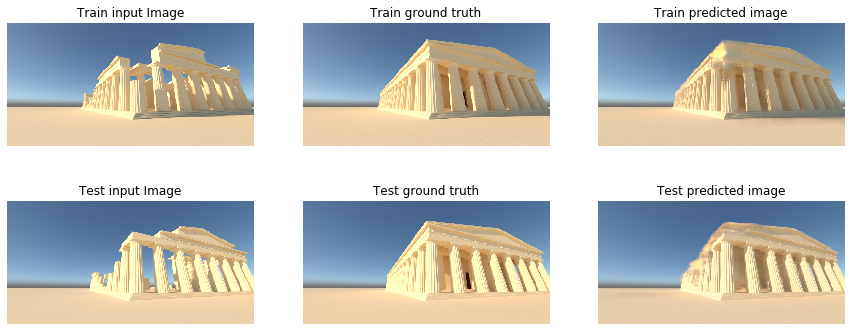

In [23]:
fit(train_dataset, test_dataset, EPOCHS)

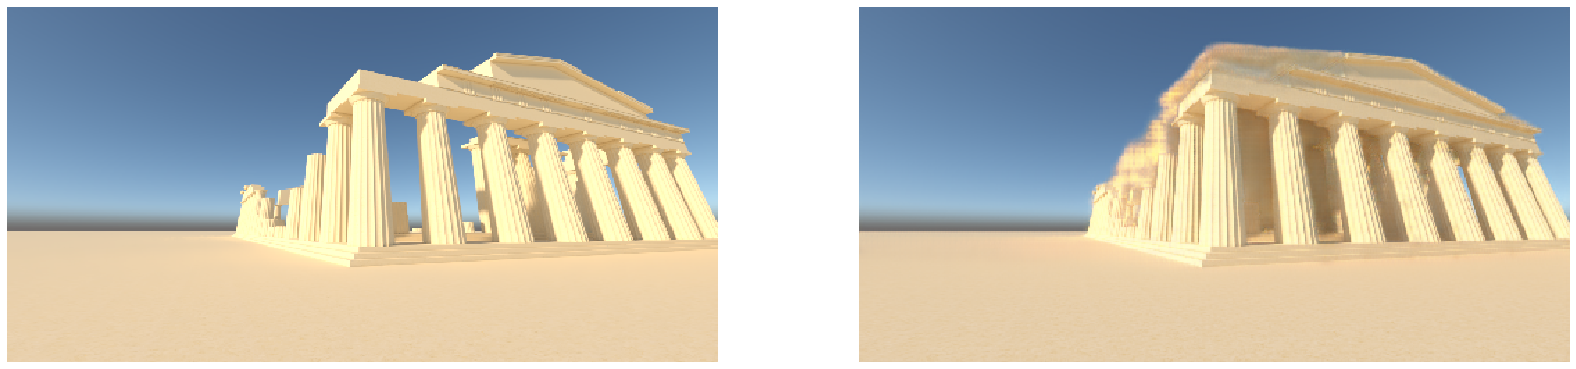

In [75]:
for test_input, test_target in test_dataset.take(1):
    fig, ax = plt.subplots(1, 2, figsize = (28, 10))
    image = generator(test_input, training = False)

    ax[1].imshow(image[0, :, :, :] * 0.5 + 0.5)
    ax[1].axis('off')
    ax[0].imshow(test_input[0, :, :, :] * 0.5 + 0.5)
    ax[0].axis('off')
    plt.show()

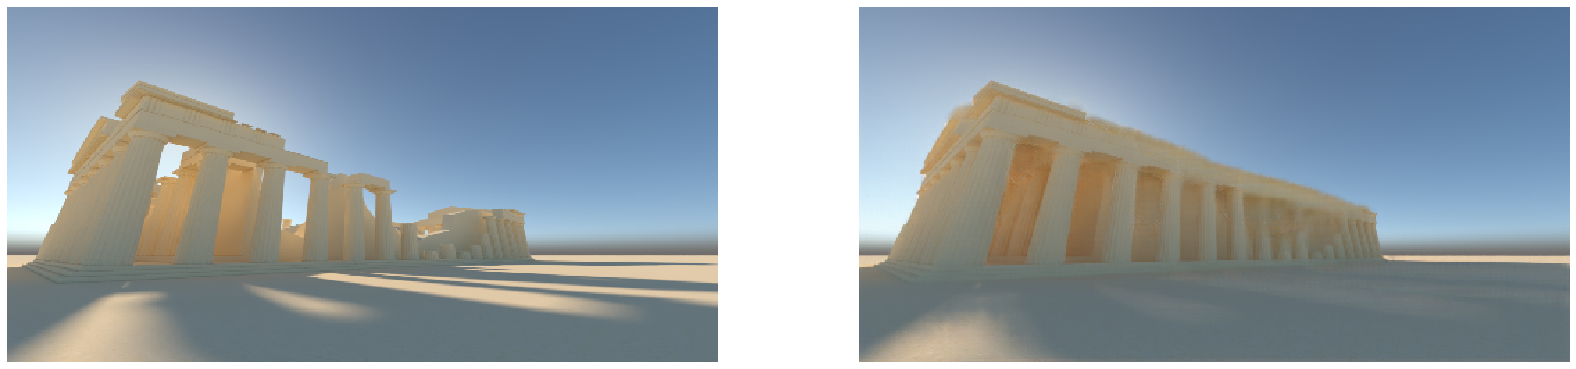

In [76]:
for test_input, test_target in train_dataset.take(1):
    fig, ax = plt.subplots(1, 2, figsize = (28, 10))
    image = generator(test_input, training = False)

    ax[1].imshow(image[0, :, :, :] * 0.5 + 0.5)
    ax[1].axis('off')
    ax[0].imshow(test_input[0, :, :, :] * 0.5 + 0.5)
    ax[0].axis('off')
    plt.show()

In [59]:
generator.save('pix2pix.h5')